# Проект 1. "Угадай знаменитость"
## Классификация изображений, распознавание лиц

***Представлены обучающий и валидационный датасеты с фотографиями пяти известных людей. Необходимо разработать классификатор на базе предобученной сверточной нейросети для распознавания по фото.*** 

Загружаем необходимые библиотеки, определяем наличие видеокарты, задаем путь к данным и размер батча для обучения.

In [376]:
import os.path
import random
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
from torchvision import models
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PATH = 'data/'
BATCH_SIZE = 32

Поскольку датасет имеет подходящий вид (фото сгруппированы в подкаталогах с названиями классов), используем готовый конструктор датасета ImageFolder.

In [377]:
!tree -d {PATH}

data/
├── train
│   ├── bill_gates
│   ├── elon_musk
│   ├── jeff_bezos
│   ├── mark_zuckerberg
│   └── steve_jobs
└── valid
    ├── bill_gates
    ├── elon_musk
    ├── jeff_bezos
    ├── mark_zuckerberg
    └── steve_jobs

12 directories


In [378]:
train_dset = torchvision.datasets.ImageFolder(os.path.join(PATH, 'train/'))
valid_dset = torchvision.datasets.ImageFolder(os.path.join(PATH, 'valid/'))

Можно просмотреть случайно выбранные фотографии.

In [379]:
def plot_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(2 * num_samples, 1.5))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title(random_label.replace("_", " ").title())
        axes[i].axis('off')

    plt.show()

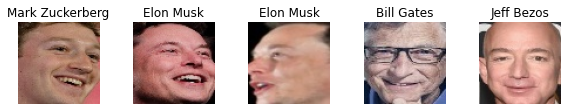

In [380]:
plot_samples(train_dset)

Выполняем предобработку обучающего и валидационного датасетов. Датасеты содержат изображения лиц низкого разрешения, как правило $70\times70$ пикселей, пропорции не соблюдаются. Переводим все изображения в стандартный формат $70\times70$, затем в PyTorch-тензор с нормализацией датасета ImageNet (будет использоваться модель, обученная на этом датасете). Для обучающего датасета добавляем аугментации: "зеркало", изменение резкости, контраста и выравнивание гистограммы. 

In [381]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dset.transform = transforms.Compose([
    transforms.Resize([70, 70]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAdjustSharpness(random.uniform(0, 2)),
    transforms.RandomAutocontrast(),
    transforms.RandomEqualize(),
    transforms.ToTensor(), 
    normalize
])

valid_dset.transform = transforms.Compose([
    transforms.Resize([70, 70]),
    transforms.ToTensor(),
    normalize
])

Создаем загрузчики данных

In [382]:
train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=os.cpu_count()
)
valid_loader = torch.utils.data.DataLoader(
    valid_dset, batch_size=BATCH_SIZE, 
    shuffle=False, num_workers=os.cpu_count()
)

Будем использовать предобученную модель EfficientNetV2-s 2021 года (arXiv:2104.00298). Выбор модели обусловлен относительно высокой точностью (acc@1 ~ 84%, acc@5 ~ 97% на датасете ImageNet) при относительно небольшом количестве параметров, ~20 млн. Немаловажно, что модель доступна в библиотеке PyTorch. Входной формат модели, $384\times384$ пикселей, больше размера наших фото, однако в модели есть адаптивный слой AdaptiveAvgPool2d, а веса согласно документации пригодны до минимального размера $33\times33$.

Меняем последний слой классификатора для соответствия количеству классов, замораживаем веса модели вплоть до 6-го блока экстрактора признаков (features): будем дообучать 6-й и 7-й блоки экстрактора и блок классификатора. Использование только 7-го блока с классификатором показывает результаты хуже, поскольку 7-й блок, по сути, не исследует признаки, а производит первые шаги уменьшения размерности вычисляемого тензора перед отправкой в классификатор. Количество обучаемых параметров у нас остается достаточно большим, более 70% полной модели, т.к. 6-й блок экстрактора признаков наиболее объемен и состоит из 15 блоков MBConv, но поскольку в целом потребляемые вычислительные ресурсы не так велики, не станем ограничиваться разморозкой только отдельных блоков MBConv внутри 6-го блока. 

Используем кросс-энтропию в качестве функции потерь и оптимизатор Adam с шагом обучения 0.0001. Модель и функцию потерь передаем на GPU (при наличии).

In [383]:
model = models.efficientnet_v2_s(
    weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model.classifier[1] = torch.nn.Linear(1280, len(train_dset.classes))

for params in model.parameters():
    params.requires_grad = True
for index, block in enumerate(model.features):
    if index < 6:
        for params in block.parameters():
            params.requires_grad = False
        
all_params = sum(p.numel() for p in model.parameters())
train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'No of parameters: {all_params}')
print(f'No of trainable parameters: {train_params}')  
    
criterion = torch.nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

No of parameters: 20183893
No of trainable parameters: 14898477


Функция для обучения модели train_model и функция process_epoch, которая вызывается из train_model и обрабатывает одну эпоху обучения для обучающей и валидационной выборок.

In [384]:
def process_epoch(model, optimizer, loader, mode='eval'):
    if mode == 'train':
        # gradient calculations on
        torch.set_grad_enabled(True)
        # model to the train mode
        model.train()
    else:
        torch.set_grad_enabled(False)
        model.eval()
        
    losses = []   # Loss function values for each batch
    matches = []  # True/False class for each sample
    
    for images, targets in loader:
        # data to GPU/CPU
        images = images.to(device)
        targets = targets.to(device)

        # forward propagation and loss function
        output = model(images)
        loss = criterion(output, targets)

        # saving metrics for a batch
        losses.append(loss.item())
        matches.extend(
            [x.item() for x in torch.argmax(output, 1) == targets])

        # back propagation and a traning step
        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Return loss function and accuracy for an epoch 
    return np.mean(losses), np.mean(matches)
  

def train_model(model, optimizer, train_loader, valid_loader, num_epochs=10):
    # Lists to save loss function values and accuracy per an epoch
    loss_train, acc_train,  loss_valid, acc_valid = [], [], [], []
    
    best_acc = 0
    for epoch in tqdm(range(num_epochs)):
        loss, acc = process_epoch(model, optimizer, train_loader, mode='train')
        loss_train.append(loss)
        acc_train.append(acc)
        
        loss, acc = process_epoch(model, optimizer, valid_loader, mode='eval')
        loss_valid.append(loss)
        acc_valid.append(acc)
        
        # Saving the best parameters
        if acc > best_acc:
            best_acc = acc
            torch.save(
                model.state_dict(), os.path.join(PATH, 'best_params.pt'))
           
    return loss_train, acc_train, loss_valid, acc_valid

Обучаем модель в течение 20 эпох.

In [385]:
loss_train, acc_train, loss_valid, acc_valid = train_model(
    model, optimizer, train_loader, valid_loader, num_epochs=20)

100%|██████████| 20/20 [03:17<00:00,  9.88s/it]


Кривые функции потерь и точности acc@1 для обучающей и валидационной выборок. Видно, что примерно после 10-й эпохи начинается тенденция к переобучению: результаты на обучающей выборке систематически лучше валидационной. На валидационной выборке достигнута точность более 98%. 

Best accuracy for the validation: 0.9869


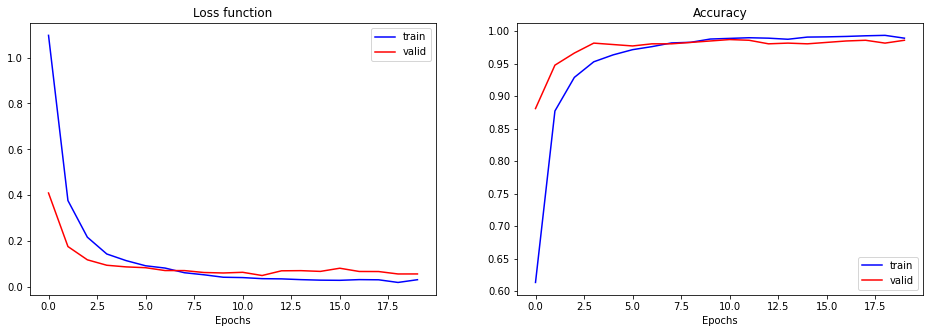

In [386]:
print(f'Best accuracy for the validation: {max(acc_valid):.4f}')

plt.figure(figsize=(16, 5))
x_max = len(loss_train)

plt.subplot(121)
plt.plot(range(x_max), loss_train, color='b', label='train')
plt.plot(range(x_max), loss_valid, color='r', label='valid')
plt.legend()
plt.title('Loss function')
plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(range(x_max), acc_train, color='b', label='train')
plt.plot(range(x_max), acc_valid, color='r', label='valid')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')

plt.show()

Для корректной работы модели на фото в идеале должны быть только лица (как в обучающем и валидационном датасетах), наличие значительного заднего плана не гарантирует правильной классификации. Попробуем взять пару фотографий из Интернета.

In [388]:
def recognize_celebrity(file, model):
    image = Image.open(file)
    display(image)
    tensor = valid_dset.transform(image)
    batch = torch.stack([tensor])
    model.eval()
    with torch.no_grad():
        output = model(batch.to(device))
    pred = output.argmax().item()
    print(train_dset.classes[pred].replace('_', ' ').title())

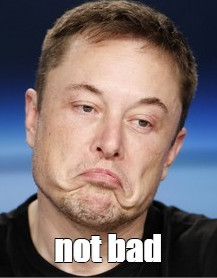

Elon Musk


In [395]:
model.load_state_dict(torch.load(os.path.join(PATH, 'best_params.pt')))
file = os.path.join(PATH, 'Musk.jpg')
recognize_celebrity(file, model)

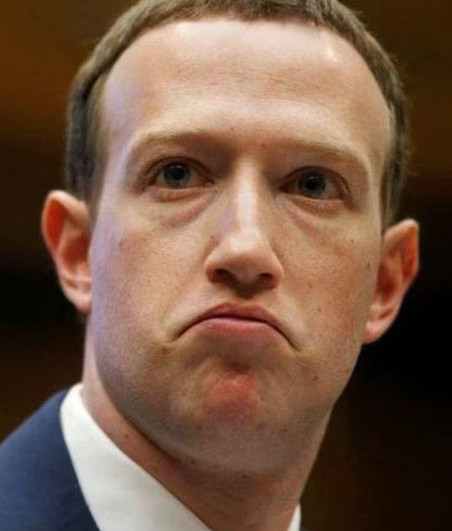

Mark Zuckerberg


In [396]:
file = os.path.join(PATH, 'Zuckerberg.jpg')
recognize_celebrity(file, model)

### Вывод

На основе предобученной модели EfficientNetV2-s разработан классификатор изображений для распознавания лиц пяти известных людей. Дообучались два последних блока экстрактора признаков и выходной классификатор (~70% весов модели). Достигнута точность на валидации более 98%. Для корректной работы модели необходимо, чтобы на фото по возможности было только лицо. Небольшой размер изображений обучающего датасета и малый размер модели позволили провести обучение (20 эпох) за время порядка 3 мин на относительно слабом GPU: GeForce GTX 1650 с 4 Гб памяти и 896 CUDA-ядрами.